In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
df_train = pd.read_csv('/dataset/signate_beginner34/train.csv')
df_test = pd.read_csv('/dataset/signate_beginner34/test.csv')
sample_submission = pd.read_csv('/dataset/signate_beginner34/sample_submission.csv')

In [3]:
df_train.columns

Index(['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [4]:
def preprocessing(df):
    data = df.copy()
    data['sc_size'] = data['sc_h'] * data['sc_w']
    data['spec'] = data['clock_speed'] * data['n_cores']

    feature = ['int_memory', 'm_dep', 'mobile_wt',
               'pc', 'px_height', 'px_width', 'ram',
               'spec']
    return data[feature]

def f1(y_pred, train_data):
    N_LABELS = 4
    reshaped_preds = y_pred.reshape(N_LABELS, len(y_pred) // N_LABELS)
    y_pred_ = reshaped_preds.argmax(axis=0)
    y_true = train_data.get_label()
    score = f1_score(y_true, y_pred_, average='macro')
    return 'f1', score, True

In [5]:
X = preprocessing(df_train)
y = df_train['price_range']

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
# 学習データを学習用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_train)

# XGBoost

In [10]:
class XGBoost:
    def __init__(self,
                 X_train, y_train,
                 X_valid, y_valid,
                 X_test, y_test):
        # 学習用
        self.train_data = xgb.DMatrix(X_train, label=y_train)
        # 検証用
        self.valid_data = xgb.DMatrix(X_valid, label=y_valid)
        # テスト用
        self.test_data = xgb.DMatrix(X_test, label=y_test)

    def train(self, params=None):
        # パラメータを設定
        if params is None:
            self.params = {
                'objective': 'multi:softprob',  # 多値分類問題
                'num_class': 4,                 # 目的変数のクラス数
                'learning_rate': 0.01,           # 学習率
                'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
            }
        else:
            self.params = params

        # 学習
        evals = [(self.train_data, 'train'), (self.valid_data, 'eval')]  # 学習に用いる検証用データ
        evaluation_results = {}                            # 学習の経過を保存する箱
        bst = xgb.train(self.params,                       # 上記で設定したパラメータ
                        self.train_data,                    # 使用するデータセット
                        num_boost_round=20000,             # 学習の回数
                        early_stopping_rounds=100,         # アーリーストッピング
                        evals=evals,                       # 学習経過で表示する名称
                        evals_result=evaluation_results,   # 上記で設定した検証用データ
                        verbose_eval=0                     # 学習の経過の表示(非表示)
                        )

        # テストデータで予測
        y_pred = bst.predict(self.test_data)
        y_pred_max = np.argmax(y_pred, axis=1)

        accuracy = accuracy_score(self.test_data.get_label(), y_pred_max)
        print('XGBoost Accuracy:', accuracy)

        return (bst, y_pred_max, accuracy)

# LightGBM

In [11]:
class LightGBM:
    def __init__(self,
                 X_train, y_train,
                 X_valid, y_valid,
                 X_test, y_test):
        # 学習用
        self.train_data = lgb.Dataset(X_train, y_train,
                                      free_raw_data=False)
        # 検証用
        self.valid_data = lgb.Dataset(X_valid, y_valid,
                                      reference=self.train_data,
                                      free_raw_data=False)
        self.test_data = lgb.Dataset(X_test, y_test, free_raw_data=False).construct()

    def train(self, params=None):
        # パラメータを設定
        if params is None:
            self.params = {
                'task': 'train',                # レーニング ⇔　予測predict
                'boosting_type': 'gbdt',        # 勾配ブースティング
                'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
                'metric': 'multi_logloss',      # 検証用データセットで、分類モデルの性能を測る指標
                'num_class': 4,                 # 目的変数のクラス数
                'learning_rate': 0.01,           # 学習率（初期値0.1）
                'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
                'min_data_in_leaf': 1,          # データの最小数（初期値20）
                'verbosity': -1
            }
        else:
            self.params = params

        # 学習
        evaluation_results = {}                                # 学習の経過を保存する箱
        model = lgb.train(self.params,                              # 上記で設定したパラメータ
                          self.train_data,                      # 使用するデータセット
                          num_boost_round=20000,               # 学習の回数
                          valid_names=['train', 'valid'],      # 学習経過で表示する名称
                          valid_sets=[self.train_data, self.valid_data],    # モデルの検証に使用するデータセット
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.log_evaluation(0),            # この数字を1にすると学習時のスコア推移がコマンドライン表示される
                              lgb.record_evaluation(evaluation_results),
                          ])

        # テストデータで予測
        y_pred = model.predict(self.test_data.get_data(), num_iteration=model.best_iteration)
        y_pred_max = np.argmax(y_pred, axis=1)

        # Accuracy の計算
        accuracy = sum(self.test_data.get_label() == y_pred_max) / len(self.test_data.get_label())
        print('LightGBM Accuracy:', accuracy)

        return(model, y_pred_max, accuracy)

# Catboost

In [12]:
class CatBoostModel:
    def __init__(self,
                 X_train, y_train,
                 X_valid, y_valid,
                 X_test, y_test):
        # 学習用
        self.train_data = Pool(X_train, label=y_train)
        # 検証用
        self.valid_data = Pool(X_valid, label=y_valid)
        self.test_data = Pool(X_test, y_test)

    def train(self, params=None):
        # パラメータを設定
        if params is None:
            self.params = {
                'loss_function': 'MultiClass',    # 多値分類問題
                'num_boost_round': 20000,          # 学習の回数
                'early_stopping_rounds': 100       # アーリーストッピングの回数
            }
        else:
            self.params = params

        # 学習
        catb = CatBoost(self.params)
        catb.fit(self.train_data, eval_set=[self.valid_data], verbose=False)

        # テストデータで予測
        y_pred = catb.predict(self.test_data, prediction_type='Probability')
        y_pred_max = np.argmax(y_pred, axis=1)

        # Accuracy の計算
        accuracy = sum(self.test_data.get_label() == y_pred_max) / len(self.test_data.get_label())
        print('CatBoost Accuracy:', accuracy)

        return (catb, y_pred_max, accuracy)

# Voting

In [15]:
xgb_params = {
    'objective': 'multi:softprob',  # 多値分類問題
    'num_class': 4,                 # 目的変数のクラス数
    'learning_rate': 0.01,           # 学習率
    'eval_metric': 'mlogloss',       # 学習用の指標 (Multiclass logloss)
}
lgbm_params = {
    'task': 'train',                # レーニング ⇔　予測predict
    'boosting_type': 'gbdt',        # 勾配ブースティング
    'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
    'metric': 'multi_logloss',      # 検証用データセットで、分類モデルの性能を測る指標
    'num_class': 4,                 # 目的変数のクラス数
    'learning_rate': 0.01,           # 学習率（初期値0.1）
    'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
    'min_data_in_leaf': 1,          # データの最小数（初期値20）
    'verbosity': -1
}
catb_params = {
    'loss_function': 'MultiClass',    # 多値分類問題
    'num_boost_round': 20000,          # 学習の回数
    'early_stopping_rounds': 100       # アーリーストッピングの回数
}

# 各5つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各5つのモデルの正答率を保存するリストの初期化
xgb_accuracies = []
lgbm_accuracies = []
catb_accuracies = []
# 学習のカウンター
loop_counts = 1

loop_num = 5
k_split_num = 5

# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# 各5つのモデルの予測を保存する配列の初期化（5seed*5cv*3モデル）
first_preds = np.zeros((len(y_test), loop_num * k_split_num * 3))


# ５つのシード値で予測
for seed_no in range(loop_num):
    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(y_train)))

    # KFoldクラスをインスタンス化（これを使って5分割する）
    K_fold = StratifiedKFold(n_splits=k_split_num, shuffle=True, random_state=seed_no)

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
        print(f'===== Trail {loop_counts} =====')
        # ilocで取り出す行を指定
        X_train_cv = X_train.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y_train).iloc[train_cv_no]
        X_eval_cv = X_train.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

        # XGBoostの学習を実行
        xgbc = XGBoost(X_train_cv, y_train_cv,
                       X_eval_cv, y_eval_cv,
                       X_test, y_test)
        bst, bst_pred, bst_accuracy = xgbc.train(params=xgb_params)

        # LightGBMの学習を実行
        lgbc = LightGBM(X_train_cv, y_train_cv,
                        X_eval_cv, y_eval_cv,
                        X_test, y_test)
        model, model_pred, model_accuracy = lgbc.train(params=lgbm_params)

        # CatBoostの学習を実行
        catc = CatBoostModel(X_train_cv, y_train_cv,
                             X_eval_cv, y_eval_cv,
                             X_test, y_test)
        catb, catb_pred, catb_accuracy = catc.train(params=catb_params)

        # 学習が終わったモデルをリストに入れておく
        xgb_models.append(bst)
        lgbm_models.append(model)
        catb_models.append(catb)

        # 学習が終わったモデルの正答率をリストに入れておく
        xgb_accuracies.append(bst_accuracy)
        lgbm_accuracies.append(model_accuracy)
        catb_accuracies.append(catb_accuracy)

        # 学習が終わったモデルの予測をリストに入れておく
        first_preds[:, loop_counts-1] = bst_pred
        first_preds[:, loop_counts-1 + 25] = model_pred
        first_preds[:, loop_counts-1 + 50] = catb_pred

        # 実行回数のカウント
        loop_counts += 1

===== Trail 1 =====
[13:31:52] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

XGBoost Accuracy: 0.4625
LightGBM Accuracy: 0.4791666666666667
CatBoost Accuracy: 0.4625
===== Trail 2 =====
[13:31:54] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

XGBoost Accuracy: 0.49583333333333335
LightGBM Accuracy: 0.5083333333333333
CatBoost Accuracy: 0.49166666666666664
===== Trail 3 =====
[13:31:58] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

XGBoost Accuracy: 0.4666666666666667
LightGBM Accuracy: 0.4625
CatBoost Accuracy: 0.48333333333333334
===== Trail 4 =====
[13:32:01] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

XGBoost Accuracy: 0.4666666666666667
LightGBM Accuracy: 0.4375
CatBoost Accuracy: 0.475
===== Trail 5 =====
[13:32:04] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

XGBoost Accuracy: 0.45416666666666666
LightGBM Accuracy:

In [16]:
# 単独のモデルでの、テストデータの正答率
print('XGBoost Accuracy: ', np.array(xgb_accuracies).mean())
print('LightGBM Accuracy: ', np.array(lgbm_accuracies).mean())
print('CatBoost Accuracy: ', np.array(catb_accuracies).mean())

XGBoost Accuracy:  0.4836666666666666
LightGBM Accuracy:  0.47883333333333333
CatBoost Accuracy:  0.4918333333333333


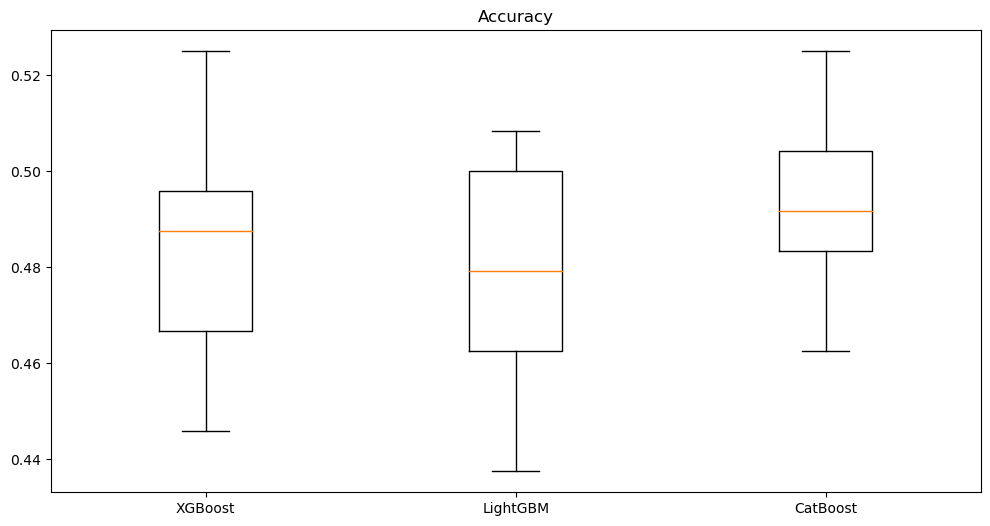

In [80]:
accuracies = [xgb_accuracies, lgbm_accuracies, catb_accuracies]
# # 箱ひげ図の作成
plt.figure(figsize=(12, 6))
plt.boxplot(accuracies, whis=3)
plt.xticks(range(1, 4), ['XGBoost', 'LightGBM', 'CatBoost'])
plt.title('Accuracy') 
plt.show()

In [84]:
# データ格納用のnumpy行列を作成
first_preds_max = pd.DataFrame(np.zeros((len(y_test), 4)))

# 予測したクラスのデータをpandas.DataFrameに入れる
df_first_preds = pd.DataFrame(first_preds)

# 各列（0,1,2）に、そのクラスを予測したモデルの数を入れる
first_preds_max[first_preds_max.columns[0]] = (df_first_preds == 0).sum(axis=1)
first_preds_max[first_preds_max.columns[1]] = (df_first_preds == 1).sum(axis=1)
first_preds_max[first_preds_max.columns[2]] = (df_first_preds == 2).sum(axis=1)
first_preds_max[first_preds_max.columns[3]] = (df_first_preds == 3).sum(axis=1)

# 各行で、そのクラスを予測したモデルの数が最も多いクラスを得る
pred_max = np.argmax(np.array(first_preds_max), axis=1)

# Accuracy を計算する
accuracy = sum(y_test == pred_max) / len(y_test)
print('accuracy:', accuracy)

df_accuracy = pd.DataFrame({'va_y': y_test,
                            'y_pred_max': pred_max})
print(pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max']))

accuracy: 0.5041666666666667
y_pred_max   0   1   2   3
va_y                      
0           11  12   9  10
1            4  34   7  15
2            6  12  61   5
3            7  24   8  15


In [105]:
X_test_data = preprocessing(df_test)
xgb_test = xgb.DMatrix(X_test_data)
lgb_test = lgb.Dataset(X_test_data)
cat_test = Pool(X_test_data)

preds = np.zeros((len(X_test_data), loop_num * k_split_num * 3))
for index, (bst, lgbm, cat) in enumerate(zip(xgb_models, lgbm_models, catb_models)):
    y_pred = bst.predict(xgb_test)
    bst_pred = np.argmax(y_pred, axis=1)
    y_pred = lgbm.predict(X_test_data, num_iteration=model.best_iteration)
    lgb_pred = np.argmax(y_pred, axis=1)
    y_pred = catb.predict(cat_test, prediction_type='Probability')
    cat_pred = np.argmax(y_pred, axis=1)

    # 学習が終わったモデルの予測をリストに入れておく
    preds[:, index] = bst_pred
    preds[:, index + 25] = lgb_pred
    preds[:, index + 50] = cat_pred

In [113]:
# データ格納用のnumpy行列を作成
preds_max = pd.DataFrame(np.zeros((len(X_test_data), 4)))

# 予測したクラスのデータをpandas.DataFrameに入れる
df_preds = pd.DataFrame(preds)

# 各列（0,1,2）に、そのクラスを予測したモデルの数を入れる
preds_max[preds_max.columns[0]] = (df_preds == 0).sum(axis=1)
preds_max[preds_max.columns[1]] = (df_preds == 1).sum(axis=1)
preds_max[preds_max.columns[2]] = (df_preds == 2).sum(axis=1)
preds_max[preds_max.columns[3]] = (df_preds == 3).sum(axis=1)

pred_max = preds_max.idxmax(axis=1)
pred_max

0      1
1      0
2      3
3      1
4      3
      ..
795    0
796    1
797    2
798    2
799    2
Length: 800, dtype: int64

In [1]:
submission = pd.concat([df_test['id'], pred_max], axis=1)
submission

NameError: name 'pd' is not defined

In [119]:
# 保存
save_folder = "results"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

submission.to_csv("{}/submit_{}.csv".format(save_folder, datetime.now().strftime("%Y-%m-%d-%H%M%S")),index=False, header=None)

In [ ]:


# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test)

# params = {
#     'objective': 'multiclass', # 多クラス分類
#     'metric': 'multi_logloss', # 損失関数にmulti_loglossを使用
#     'num_class': 4, # クラスの数
#     'boosting_type': 'gbdt',
#     'lambda_l1': 0.2,
#     'lambda_l2': 0.2,
#     'learning_rate':0.01,
#     'drop_rate':0.5,
#     # 'max_depth': 3,
#     'verbosity': -1,
# }
# verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
# lgb_model = lgb.train(params,
#                   train_data,
#                   num_boost_round=10000,
#                   valid_sets=[train_data, test_data],
#                   feval=f1,
#                   callbacks=[
#                       lgb.early_stopping(stopping_rounds=10, verbose=True),
#                       lgb.log_evaluation(verbose_eval) # この数字を1にすると学習時のスコア推移がコマンドライン表示される
#                   ])

# y_pred = lgb_model.predict(X_test)
# y_pred_class = np.argmax(y_pred, axis=1)
# y_pred_class

# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_test, y_pred_class))

# score = f1_score(y_test, y_pred_class, average='macro')
# score

# plt.figure(figsize=(10, 6))
# lgb.plot_importance(lgb_model)
# plt.show()

# train_data = xgb.DMatrix(X_train, label=y_train)
# test_data = xgb.DMatrix(X_test, label=y_test)

# params = {
#     'objective': 'multi:softprob', # 多クラス分類
#     'num_class': 4, # クラスの数
#     'booster': 'gbtree',
#     'learning_rate':0.01,
#     'max_depth': 5,
#     'reg_alpha': 0.2,
# }
# history = {}
# verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
# xgb_model = xgb.train(params,
#                   train_data,
#                   num_boost_round=10000,
#                   # feval=f1,
#                   early_stopping_rounds=50,
#                   evals=[(train_data, "train"), (test_data, "test")],
#                   evals_result=history,
#                  )

# y_pred = xgb_model.predict(test_data)
# y_pred_class = np.argmax(y_pred, axis=1)
# y_pred_class

# print(accuracy_score(y_test, y_pred_class))

# score = f1_score(y_test, y_pred_class, average='macro')
# score

# xgb.plot_importance(xgb_model)

In [50]:
# from sklearn.model_selection import KFold
# # クロスバリデーション用のScikit-Learnクラス（5分割KFold）
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ###### ここからがLightGBMの実装 ######
# # データをDatasetクラスに格納
# dcv = lgb.Dataset(X, label=y)  # クロスバリデーション用
# # 使用するパラメータ
# params = {
#     'objective': 'multiclass', # 多クラス分類
#     'num_class': 4, # クラスの数
#     'metric': 'multi_logloss', # 損失関数にmulti_loglossを使用
#     'random_state': 42,  # 乱数シード
#     'boosting_type': 'gbdt',
#     'reg_alpha': 0.0,
#     'reg_lambda': 0.0,
#     'learning_rate':0.01, 
#     'drop_rate':0.5,
#     'verbose': -1
# }
# verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
# # early_stoppingを指定してLightGBMをクロスバリデーション
# cv_result = lgb.cv(params, dcv,
#                 num_boost_round=10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
#                 folds=cv,
#                 feval=f1,
#                 callbacks=[lgb.early_stopping(stopping_rounds=100, 
#                                 verbose=True), # early_stopping用コールバック関数
#                            lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
#                 )
# # print(cv_result)
# print(f'multi logloss mean={cv_result["multi_logloss-mean"][-1]}')

# test_data = preprocessing(df_test)
# pred = ddmodel.predict(test_data)
# pred_class = np.argmax(pred, axis=1)
# pred_class

In [14]:
test_data = preprocessing(df_test)
# pred = model.predict(test_data)
# pred_class = np.argmax(pred, axis=1)

emsemble_test = pd.DataFrame({
    'XGB': np.argmax(xgb_model.predict(xgb.DMatrix(test_data)), axis=1),
    'LGB': np.argmax(lgb_model.predict(test_data), axis=1)
    })
emsemble_test

,XGB,LGB
0,3,1
1,2,2
2,3,0
3,3,1
4,3,2
...,...,...
795,0,0
796,1,1
797,3,2
798,2,2


In [15]:
mean = emsemble_test['LGB'] * 0.8 + emsemble_test['XGB'] * 0.2
pred_class = mean.round().astype(int)
pred_class

0      1
1      2
2      1
3      1
4      2
      ..
795    0
796    1
797    2
798    2
799    2
Length: 800, dtype: int64

In [53]:
# sample_submission['2'] = proba
submission = pd.concat([df_test['id'], pd.DataFrame(pred_class)], axis=1)
submission

,1,0
0,1,1
1,2,2
2,6,1
3,10,1
4,12,2
...,...,...
795,1978,2
796,1980,1
797,1982,2
798,1988,2


In [54]:
# 保存
save_folder = "results"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

submission.to_csv("{}/submit_{}.csv".format(save_folder, datetime.now().strftime("%Y-%m-%d-%H%M%S")),index=False, header=None)